In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix

# ===============================
# 설정
# ===============================
DATA_DIR = "이미지"   # 강서체육공원 / 대저생태공원 / 맥도생태공원
BATCH_SIZE = 16
EPOCHS = 10                  # 초안이니 짧게
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ===============================
# 데이터 전처리
# ===============================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
class_names = dataset.classes
num_classes = len(class_names)

print("클래스:", class_names)
print("전체 이미지 수:", len(dataset))

# ===============================
# Train / Val 분리
# ===============================
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

# ===============================
# 모델 (ResNet50)
# ===============================
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(DEVICE)

# ===============================
# 손실함수 & 옵티마이저
# ===============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# ===============================
# 학습
# ===============================
for epoch in range(EPOCHS):
    model.train()
    train_correct, train_total = 0, 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_acc = train_correct / train_total * 100

    # ===============================
    # Validation
    # ===============================
    model.eval()
    val_correct, val_total = 0, 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)

            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total * 100

    print(f"[Epoch {epoch+1}] Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

# ===============================
# 모델 저장
# ===============================
torch.save(model.state_dict(), "resnet50_gangseo_baseline.pth")
print("모델 저장 완료")


클래스: ['UN공원', '강서체육공원', '금강공원', '금정산성', '대저생태공원', '동래온천', '동래읍성', '맥도생태공원', '범어사', '부산박물관', '부산치유의숲', '부산프리미엄아울렛', '부산항대교', '부전마켓타운', '상해거리', '서동미로시장', '성지곡수원지', '송상현광장', '아홉산숲', '안데르센 동화마을', '야구등대', '오륙도스카이워크', '용호만유람선', '이기대도시자연공원', '일광해수욕장', '임랑해수욕장', '장안사', '전포카페거리', '초량이바구길', '호천마을', '황령산', '회동수원지']
전체 이미지 수: 3990


Epoch 1/10: 100%|██████████| 200/200 [02:06<00:00,  1.58it/s]


[Epoch 1] Train Acc: 39.91% | Val Acc: 54.51%


Epoch 2/10: 100%|██████████| 200/200 [02:03<00:00,  1.63it/s]


[Epoch 2] Train Acc: 67.26% | Val Acc: 57.52%


Epoch 3/10: 100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


[Epoch 3] Train Acc: 81.39% | Val Acc: 61.40%


Epoch 4/10: 100%|██████████| 200/200 [15:26<00:00,  4.63s/it]   


[Epoch 4] Train Acc: 89.10% | Val Acc: 62.91%


Epoch 5/10: 100%|██████████| 200/200 [18:58<00:00,  5.69s/it]   


[Epoch 5] Train Acc: 93.48% | Val Acc: 61.78%


Epoch 6/10: 100%|██████████| 200/200 [02:04<00:00,  1.60it/s]


[Epoch 6] Train Acc: 94.83% | Val Acc: 64.79%


Epoch 7/10: 100%|██████████| 200/200 [27:59<00:00,  8.40s/it]   


[Epoch 7] Train Acc: 95.80% | Val Acc: 62.03%


Epoch 8/10: 100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


[Epoch 8] Train Acc: 96.21% | Val Acc: 63.91%


Epoch 9/10: 100%|██████████| 200/200 [03:40<00:00,  1.10s/it]


[Epoch 9] Train Acc: 96.99% | Val Acc: 63.28%


Epoch 10/10: 100%|██████████| 200/200 [02:19<00:00,  1.43it/s]


[Epoch 10] Train Acc: 97.34% | Val Acc: 61.53%
모델 저장 완료


In [19]:
# ===============================
# Confusion Matrix
# ===============================
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1).cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)

print("\nConfusion Matrix")
print(cm)

print("\n클래스 순서:", class_names)



Confusion Matrix
[[43  1  0 ...  0  0  1]
 [ 4  7  0 ...  0  0  1]
 [ 0  0  6 ...  0  1  0]
 ...
 [ 0  0  1 ... 16  0  0]
 [ 0  0  0 ...  1 13  0]
 [ 0  0  0 ...  0  0 11]]

클래스 순서: ['UN공원', '강서체육공원', '금강공원', '금정산성', '대저생태공원', '동래온천', '동래읍성', '맥도생태공원', '범어사', '부산박물관', '부산치유의숲', '부산프리미엄아울렛', '부산항대교', '부전마켓타운', '상해거리', '서동미로시장', '성지곡수원지', '송상현광장', '아홉산숲', '안데르센 동화마을', '야구등대', '오륙도스카이워크', '용호만유람선', '이기대도시자연공원', '일광해수욕장', '임랑해수욕장', '장안사', '전포카페거리', '초량이바구길', '호천마을', '황령산', '회동수원지']


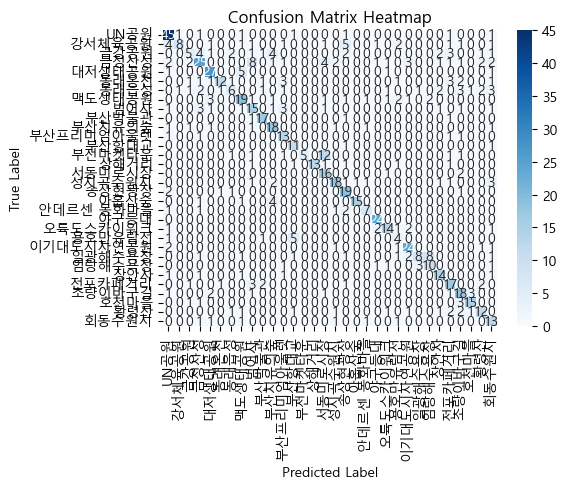

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

font_path = "C:/Windows/Fonts/malgun.ttf"  # 윈도우
font = font_manager.FontProperties(fname=font_path).get_name()
rc("font", family=font)

plt.rcParams["axes.unicode_minus"] = False
# ===============================
# Confusion Matrix 계산
# ===============================
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1).cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)

# ===============================
# Heatmap 시각화
# ===============================
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.tight_layout()
plt.show()


ResNet Epoch [1/20] Loss: 520.3171
ResNet Epoch [2/20] Loss: 351.2270
ResNet Epoch [3/20] Loss: 304.5620
ResNet Epoch [4/20] Loss: 270.7642
ResNet Epoch [5/20] Loss: 251.9731
ResNet Epoch [6/20] Loss: 243.4641
ResNet Epoch [7/20] Loss: 231.1780
ResNet Epoch [8/20] Loss: 218.2062
ResNet Epoch [9/20] Loss: 208.4458
ResNet Epoch [10/20] Loss: 205.1172
ResNet Epoch [11/20] Loss: 192.8152
ResNet Epoch [12/20] Loss: 185.9005
ResNet Epoch [13/20] Loss: 183.8837
ResNet Epoch [14/20] Loss: 177.6460
ResNet Epoch [15/20] Loss: 177.8525
ResNet Epoch [16/20] Loss: 173.0515
ResNet Epoch [17/20] Loss: 166.2839
ResNet Epoch [18/20] Loss: 155.8431
ResNet Epoch [19/20] Loss: 154.6377
ResNet Epoch [20/20] Loss: 152.2984


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Dell 3571/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 64.8MB/s] 


VGG Epoch [1/20] Loss: 417.8364
VGG Epoch [2/20] Loss: 276.3013
VGG Epoch [3/20] Loss: 242.3538
VGG Epoch [4/20] Loss: 214.8315
VGG Epoch [5/20] Loss: 198.1456
VGG Epoch [6/20] Loss: 184.9018
VGG Epoch [7/20] Loss: 178.2302
VGG Epoch [8/20] Loss: 162.3631
VGG Epoch [9/20] Loss: 155.4231
VGG Epoch [10/20] Loss: 158.6653
VGG Epoch [11/20] Loss: 150.3969
VGG Epoch [12/20] Loss: 148.2674
VGG Epoch [13/20] Loss: 139.4801
VGG Epoch [14/20] Loss: 130.0580
VGG Epoch [15/20] Loss: 138.1537
VGG Epoch [16/20] Loss: 139.9599
VGG Epoch [17/20] Loss: 133.8040
VGG Epoch [18/20] Loss: 122.7013
VGG Epoch [19/20] Loss: 132.9028
VGG Epoch [20/20] Loss: 129.8573


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\Dell 3571/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 51.5MB/s]


EfficientNet Epoch [1/20] Loss: 546.2860
EfficientNet Epoch [2/20] Loss: 382.0964
EfficientNet Epoch [3/20] Loss: 329.0794
EfficientNet Epoch [4/20] Loss: 293.5923
EfficientNet Epoch [5/20] Loss: 271.9485
EfficientNet Epoch [6/20] Loss: 253.0922
EfficientNet Epoch [7/20] Loss: 237.7729
EfficientNet Epoch [8/20] Loss: 230.1311
EfficientNet Epoch [9/20] Loss: 219.6507
EfficientNet Epoch [10/20] Loss: 210.0968
EfficientNet Epoch [11/20] Loss: 200.5200
EfficientNet Epoch [12/20] Loss: 199.8368
EfficientNet Epoch [13/20] Loss: 196.8559
EfficientNet Epoch [14/20] Loss: 184.4090
EfficientNet Epoch [15/20] Loss: 182.9391
EfficientNet Epoch [16/20] Loss: 176.9075
EfficientNet Epoch [17/20] Loss: 176.5899
EfficientNet Epoch [18/20] Loss: 167.0447
EfficientNet Epoch [19/20] Loss: 164.0752
EfficientNet Epoch [20/20] Loss: 164.0466

🔥 Ensemble Accuracy: 66.79%


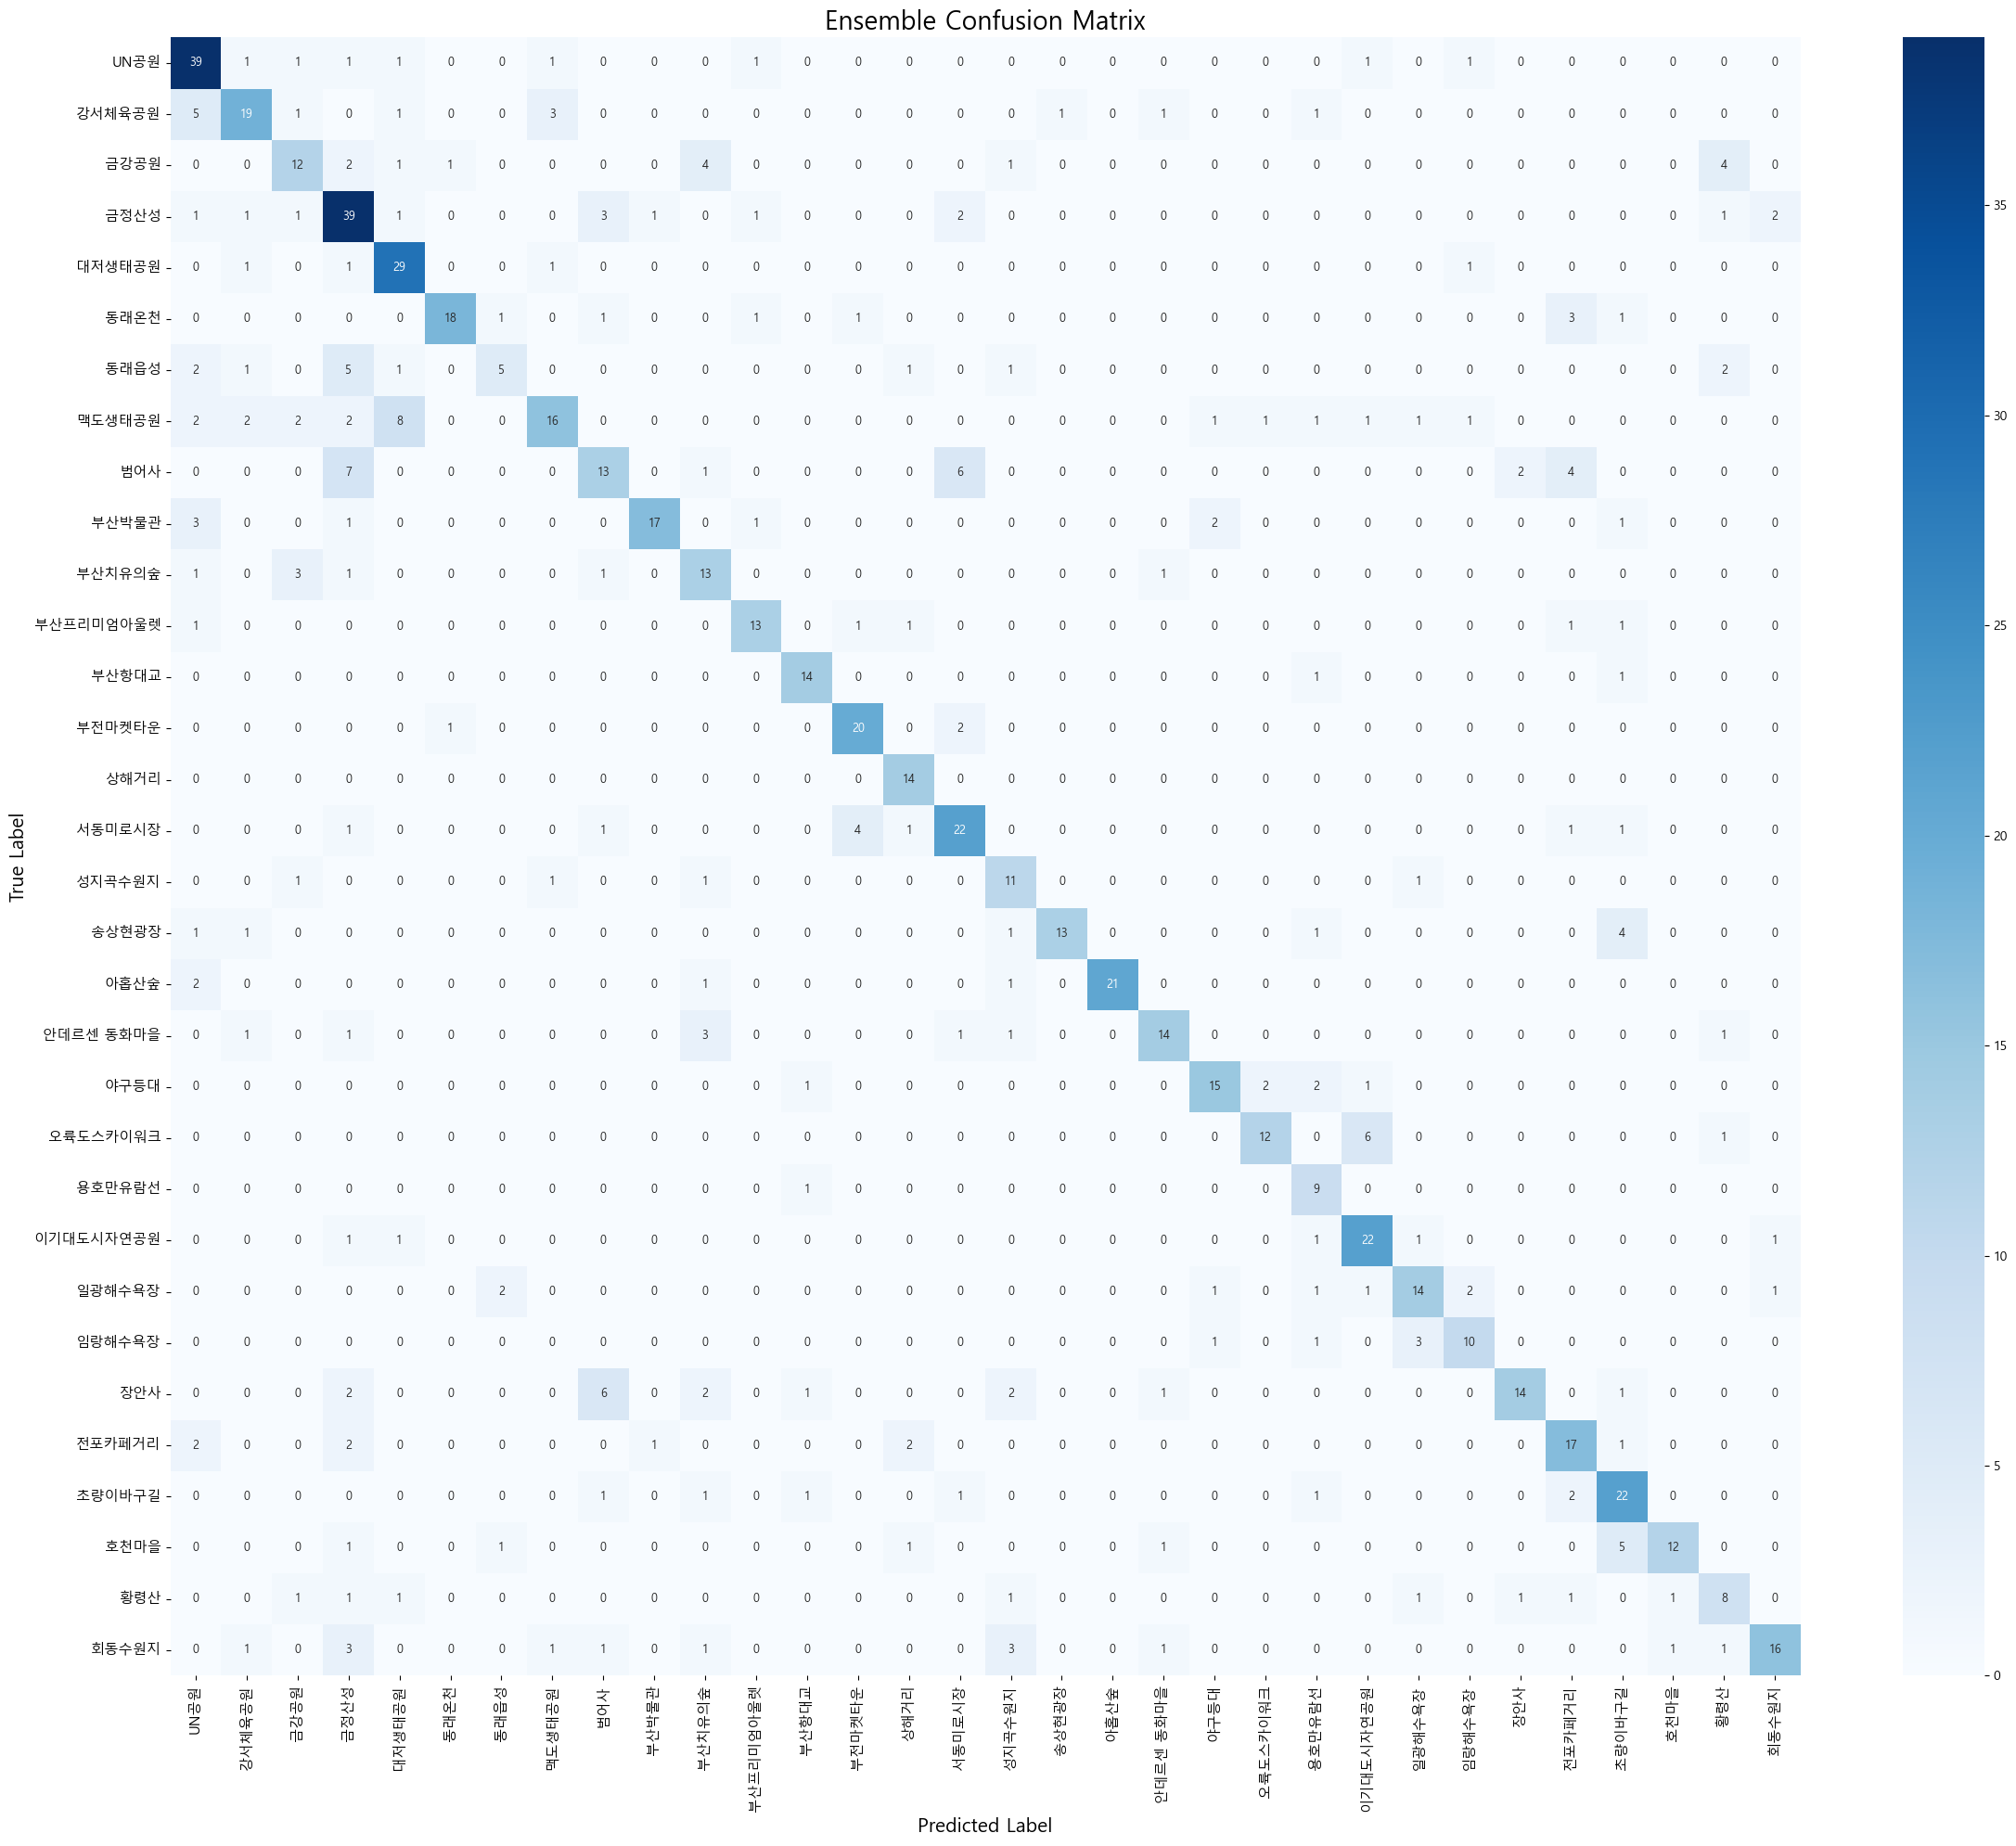

In [21]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =====================
# 1. 기본 설정
# =====================
DATA_DIR = "이미지"
BATCH_SIZE = 16
EPOCHS = 20
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# =====================
# 2. Transform
# =====================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# =====================
# 3. Dataset & Loader
# =====================
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
class_names = dataset.classes
num_classes = len(class_names)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# =====================
# 4. 모델 생성 함수
# =====================
def build_resnet():
    model = models.resnet50(weights="IMAGENET1K_V1")
    for p in model.parameters():
        p.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def build_vgg():
    model = models.vgg16(weights="IMAGENET1K_V1")
    for p in model.parameters():
        p.requires_grad = False
    model.classifier[6] = nn.Linear(4096, num_classes)
    return model

def build_effnet():
    model = models.efficientnet_b0(weights="IMAGENET1K_V1")
    for p in model.parameters():
        p.requires_grad = False
    model.classifier[1] = nn.Linear(
        model.classifier[1].in_features, num_classes
    )
    return model

# =====================
# 5. 학습 함수
# =====================
def train_model(model):
    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(EPOCHS):
        running_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"{model.__class__.__name__} Epoch [{epoch+1}/{EPOCHS}] "
              f"Loss: {running_loss:.4f}")
    return model

# =====================
# 6. 학습 실행
# =====================
resnet = train_model(build_resnet())
vgg = train_model(build_vgg())
effnet = train_model(build_effnet())

models_list = [resnet, vgg, effnet]

# =====================
# 7. 앙상블 예측
# =====================
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)

        probs = 0
        for m in models_list:
            m.eval()
            probs += F.softmax(m(imgs), dim=1)

        probs /= len(models_list)
        preds = torch.argmax(probs, dim=1)

        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.numpy())

# =====================
# 8. 정확도
# =====================
acc = accuracy_score(y_true, y_pred)
print(f"\n🔥 Ensemble Accuracy: {acc*100:.2f}%")

# =====================
# 9. Confusion Matrix (크게)
# =====================
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(24, 20))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={"size": 9}
)

plt.title("Ensemble Confusion Matrix", fontsize=20)
plt.xlabel("Predicted Label", fontsize=15)
plt.ylabel("True Label", fontsize=15)
plt.xticks(rotation=90, fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()
